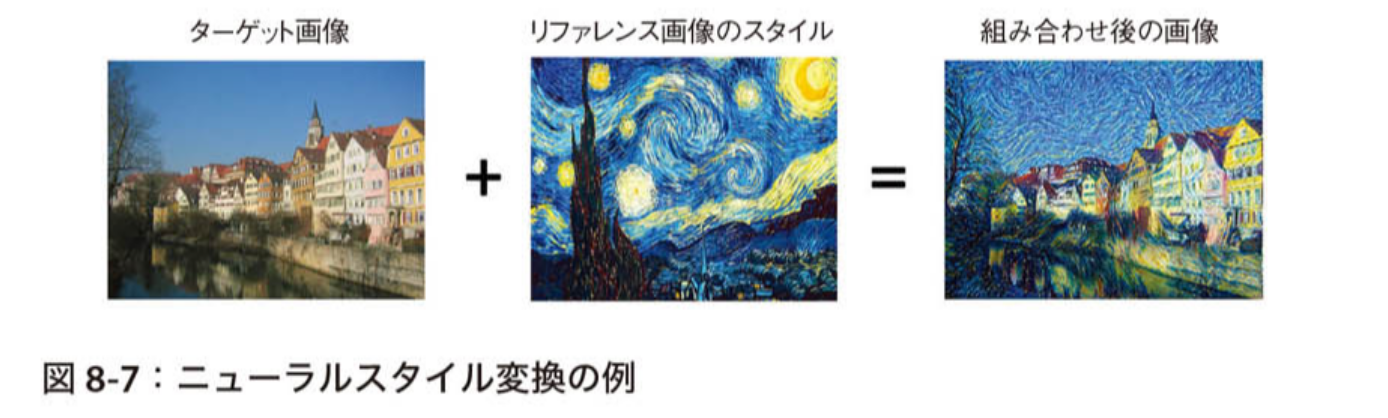

In [1]:
# 画像の表示
from IPython.display import Image
Image(filename='IMG/01.png', width=600)

スタイル : ゴッホの青と黄の円を描くような筆つかい<br>
コンテンツ : ドイツの写真の街並み<br>

スタイル変換自体は、以前から存在したが、ディープラーニングベースのスタイル変換の方がはるかに上。<br>
コンピュータビジョンのクリエイティブな応用は新たな夜明けを迎えている。<br>

何を達成したいのかを指定するための損失関数を定義し、<br>
この損失関数を最小化する。<br>
ここで達成したいことは、<br>
「元の画像のコンテンツを維持した上で、リファレンス画像のスタイルを取り入れること」<br>

最小化の対象にすべき損失関数は以下のように定義される。<br>

In [2]:
loss = distance(style(reference_image) - style(generated_image))+
           distance(content(original_image) - content(generated_image))

SyntaxError: invalid syntax (<ipython-input-2-ccc076322887>, line 1)

content : 画像からそのコンテンツの表現を計算する関数。<br>
style : 画像からそのスタイルの表現を計算する関数。<br>

### コンテンツの損失関数

ネットワークの入力側に近い活性化には、画像に関する「局所的な」情報が含まれているが、<br>
出力側に近づくほど「大域的で抽象的な」情報が含まれるようになる。<br>

コンテンツの損失関数の候補として有力なのはL2ノルムである。<br>
このL2ノルムは、学習済みのCNNにおいて（ターゲット画像で）計算された出力側の層の活性化と、<br>
(生成された画像で）計算された同じ層の活性化との間の距離を表している。<br>

したがってCNNの出力側の層から見た場合に、生成された画像が元のターゲット画像と、<br>
同じように見えることが保証される。<br>

### スタイルの損失関数

CNNによって全ての空間規模でスタイルリファレンス画像の外観を捕捉することになる。<br>
スタイルの損失関数に関しては、層の活性化のグラム行列を使用している。<br>
グラム行列は、与えられた層の特徴マップ同士の内積である。<br>
この内積については、その層の特徴量どうしの相関関係を表すマップとして考えることができる。<br>

こうした特徴量の相関関係には、特定の空間規模での統計的パターンが反映されている。<br>
経験上、それらはこの空間規模で抽出されるテクスチャの外観に対応している。<br>

したがって、スタイルの損失関数の目的は、スタイルリファレンス画像と生成された画像とで、<br>
さまざまな層の活性化に含まれる相関関係を同じに保つことにある。<br>
それにより、特定の空間規模で抽出されたテクスチャが、<br>
スタイルリファレンス画像でも生成された画像でも同じように見えることが保証される。<br>

### コンテンツとスタイルのイメージ

<ul>
   <li>コンテンツのターゲット画像と生成された画像との間で出力側の層の活性化を同様に保つことで、<br>
       コンテンツを維持する。CNNからはターゲット画像と生成された画像が同じものを含んでいるように「見える」。<br>
    </li>
    <li>入力側の層と出力側の層の両方で活性化の「相関関係」を同じに保つことで、スタイルを維持する。<br>
        特徴量の相関関係は「テクスチャ」を捕捉する。<br>
        スタイルリファレンス画像と生成された画像のテクスチャはさまざまな空間規模で同じになるはず。<br>
    </li>
</ul>

### Kerasでのニューラルスタイル変換

全体的な流れは以下のよう。<br>
<ol>
    <li>スタイルリファレンス画像、ターゲット画像、生成された画像に対して、VGG19の層の活性化を同時に計算するネットワークを準備。</li>
    <li>これら３つの画像に渡って計算された層の活性化を元に、上記で説明した損失関数を定義。<br>
        スタイル変換を実現するには損失関数を最小化する。
    </li>
    <li>この損失関数を最小化するための勾配降下法のプロセスを定義。</li>
</ol>

まず、スタイルリファレンス画像とターゲット画像へのパスを定義。<br>
処理した画像が同じになるようにする。<br>

In [3]:
from keras.preprocessing.image import load_img, img_to_array

# 変換したい画像へのパス
target_image_path = 'NN/portrait.jpg'

# スタイル画像へのパス
style_reference_image_path = 'NN/style.jpg'

# 生成する画像のサイズ
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

/Users/Takanori/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


次に、VGG19ネットワークでやり取りされる画像の読み込み、前処理、後処理を行う補助関数を用意。<br>

In [4]:
# 補助関数
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # ImageNetから平均ピクセル値を取り除くことにより、中心を０に設定
    # これにより、vgg19.preprocess_inputによって実行される変換が逆になる。
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BGRからRGBに変換
    # これもvgg19.preprocess_inputの変換を逆にするための措置
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

VGG19ネットワークの定義。<br>
このネットワークは、<br>
スタイルリファレンス画像、ターゲット画像、そして生成された画像をそれぞれ保持する、<br>
プレースホルダの３つを入力として使用。<br>

プレースホルダとは記号的なテンソルのことであり、プレースホルダの値はNumpyを通じて外部から提供される。<br>
スタイルリファレンスとターゲット画像は静的なので、K.constantを使って定義。<br>
対照的に生成された画像のプレースホルダに含まれる数値は徐々に変化する。<br>

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

#  生成された画像を保持するプレースホルダ
combination_image = K.placeholder((1, img_height, img_width, 3))

# 3つの画像を１つのバッチにまとめる
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

# 3つの画像からなるバッチを入力として使用するVGG19モデルを構築
# このモデルには、学習済みのImageNetの重みが読み込まれる。
model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)
print('Model loaded')

Model loaded


この損失関数は、VGG19ネットワークの最後の層が「見る」ターゲット画像と生成された生成された画像が同じようになるようにする。<br>

In [6]:
# コンテンツの損失関数
# 平均二乗誤差
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

スタイルの損失関数を定義する。<br>
補助関数を使って入力行列のグラム行列を計算する。<br>

In [7]:
# スタイルの損失関数

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

全変動損失関数を定義。<br>
生成された画像のピクセルを操作して、生成された画像を空間的に連続させることで、過度の画素化を回避。<br>
この損失関数については、正則化損失関数として考えるとOK。<br>

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

最小化の対象となるのは、これら３つの損失関数の荷重平均。<br>
コンテンツの損失関数の計算では、出力側の出力側の層を一つだけ使用する。<br>
これに対し、スタイルの損失関数の計算では、入力側から出力側までの一連の層を使用する。<br>
そして最後に、全変動損失を追加する。<br>

In [9]:
# 層の名前を活性化テンソルにマッピングするディクショナリ
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# コンテンツの損失関数に使用する層の名前
content_layer = 'block5_conv2'
# スタイルの損失関数に使用する層の名前
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 損失関数の荷重平均の重み
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# 全てのコンポーネントをこのスカラー変数に追加することで、損失関数を定義
loss = K.variable(0.)
# コンテンツの損失関数を追加
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

最適化の実行にL-BFGSアルゴリズムを使用。<br>

In [10]:
# 損失関数をもとに、生成された画像の勾配を取得
grads = K.gradients(loss, combination_image)[0]

# 現在の損失関数の値と勾配の値を取得する関数
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

SciPyのL-BFGSアルゴリズムを使って勾配上昇法を実行し、イテレーションごとに生成された画像を保存。<br>

In [11]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 初期状態: ターゲット画像
x = preprocess_image(target_image_path)

# 画像を平坦化
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 280335070.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 173s
Start of iteration 1


/Users/Takanori/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 122837890.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 164s
Start of iteration 2
Current loss value: 79706664.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 164s
Start of iteration 3
Current loss value: 61279796.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 164s
Start of iteration 4
Current loss value: 51441380.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 164s
Start of iteration 5
Current loss value: 44724468.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 164s
Start of iteration 6
Current loss value: 39843620.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 164s
Start of iteration 7
Current loss value: 35898820.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 164s
Start of iteration 8
Current loss value: 33069660.0
Im